In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
from statsmodels.stats.diagnostic import het_arch 

In [3]:
!pip install arch
import arch

### Leer datos de tipo de cambio colones/dólar

In [93]:
tc = pd.read_csv("tipo-cambio.csv", parse_dates=[0])
tc.set_index(tc.columns[0], inplace=True)
tc.index.name = ''
#tc *= 100

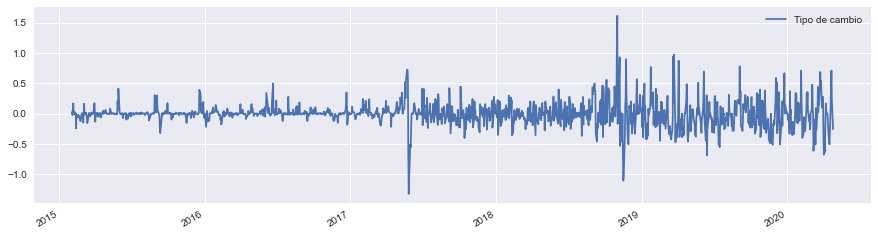

In [94]:
tc.plot(figsize=[15,4])

### Obtener los cuadrados de los residuos de la ecuación de la media

In [95]:
e = ols('tc~1', tc).fit().resid
e2 = e**2

### Mostrar el autocorrelograma de los cuadrados de los residuos

In [96]:
OPCIONES = dict(lags=48, alpha=0.05, title='')
plot_acf = sm.graphics.tsa.plot_acf
plot_pacf = sm.graphics.tsa.plot_pacf

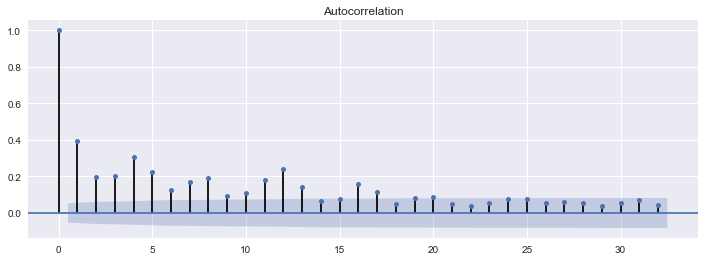

In [97]:
fig, ax =  plt.subplots(figsize=[12,4])
plot_acf(e2, ax=ax);

### Determinar si hay efectos ARCH, test de multiplicador de lagrange

**het_arch**

Returns: 

* lmfloat:  Lagrange multiplier test statistic
* lmpvalfloat: p-value for Lagrange multiplier test
* fvalfloat: fstatistic for F test, alternative version of the same test based on F test for the parameter restriction
* fpvalfloat: pvalue for F test

In [98]:
pd.DataFrame([(lag, *het_arch(e, nlags=lag, autolag=None, store=False, ddof=0)[:2]) for lag in range(1, 16)],
             columns=['lags','chi2', 'Prob > chi2']).set_index('lags').round(3)

,chi2,Prob > chi2
lags,,
1,209.419,0.0
2,212.541,0.0
3,231.625,0.0
4,283.783,0.0
5,284.577,0.0
6,284.471,0.0
7,291.968,0.0
8,293.769,0.0
9,298.060,0.0


## Ajuste de un modelo ARCH

In [99]:
for p in range(1,12):
    res = arch.arch_model(tc, mean='constant', vol='arch', q=0, p=p, rescale=False).fit(disp='off')
    print(q, res.aic, res.bic)

11 -991.5161010083825 -975.8593718855253
11 -1205.0685378035753 -1184.192898973099
11 -1270.1155541272847 -1244.0210055891894
11 -1310.4629264165155 -1279.1494681708011
11 -1353.5112248287899 -1316.9788568754564
11 -1374.268874972025 -1332.5175973110727
11 -1375.9646054566956 -1328.9944180881241
11 -1381.5653221487833 -1329.3762250725927
11 -1398.8046970284045 -1341.3966902445948
11 -1415.086196362194 -1352.4592798707652
11 -1413.0870636624659 -1345.2412374634182


In [120]:
res = arch.arch_model(tc, mean='constant', vol='arch', q=0, p=10, rescale=False).fit(disp='off')
res

                      Constant Mean - ARCH Model Results                      
Dep. Variable:         Tipo de cambio   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:                719.543
Distribution:                  Normal   AIC:                          -1415.09
Method:            Maximum Likelihood   BIC:                          -1352.46
                                        No. Observations:                 1365
Date:                Tue, Sep 08 2020   Df Residuals:                     1353
Time:                        18:55:22   Df Model:                           12
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.3959e-03  3.374e-03      0.710      0.478 

In [101]:
fcast = res.forecast(horizon=40, start=-1)

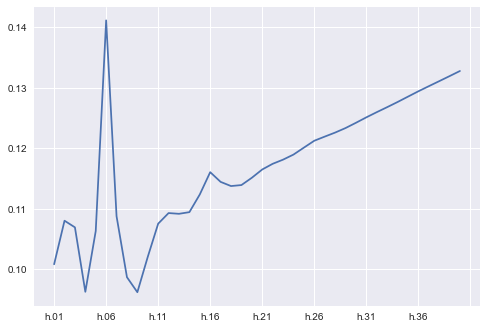

In [102]:
fcast.variance.iloc[-1].plot()

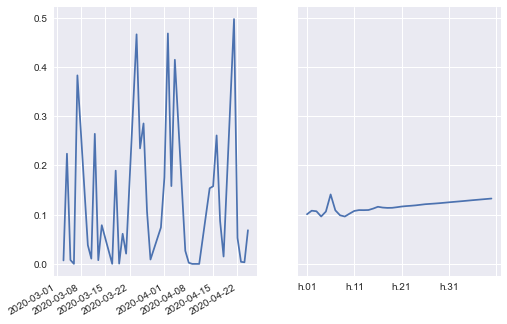

In [105]:
fig, axs = plt.subplots(1,2,sharey=True)
fcast.residual_variance.iloc[-1].plot(ax=axs[1])
e2['2020-03-01':].plot(ax=axs[0])

In [115]:
for q in range(0, 3):
    for p in range(1, 5):    
        res = arch.arch_model(tc, vol='garch', q=q, p=p, rescale=False).fit(disp='off')
        print(q, p, res.aic, res.bic)

0 1 -991.5161009430665 -975.8593718202093
0 2 -1205.0685372680412 -1184.192898437565
0 3 -1270.1155545820986 -1244.0210060440033
0 4 -1310.4629268072213 -1279.1494685615069
1 1 -1417.636575341844 -1396.7609365113678
1 2 -1415.6286719943362 -1389.5341234562409


C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


1 3 -1413.8232197653658 -1382.5097615196514
1 4 -1411.6365717853182 -1375.1042038319847
2 1 -1411.2563922029196 -1385.1618436648243
2 2 -1424.5279951410507 -1393.2145368953363
2 3 -1422.5280013619902 -1385.9956334086567
2 4 -1420.527987129044 -1378.7767094680917


In [123]:
res = arch.arch_model(tc, vol='garch', q=2, p=3, rescale=False).fit(disp='off')
print(q, p, res.aic, res.bic)
res

2 4 -1422.5280013619902 -1385.9956334086567


                     Constant Mean - GARCH Model Results                      
Dep. Variable:         Tipo de cambio   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                718.264
Distribution:                  Normal   AIC:                          -1422.53
Method:            Maximum Likelihood   BIC:                          -1386.00
                                        No. Observations:                 1365
Date:                Tue, Sep 08 2020   Df Residuals:                     1358
Time:                        18:56:48   Df Model:                            7
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.0855e-03  3.344e-03      0.923      0.356 

In [125]:
!pip install pyflux


  Using cached pyflux-0.4.15.tar.gz (1.3 MB)
  Using cached numdifftools-0.9.39-py2.py3-none-any.whl (953 kB)
  Running setup.py clean for pyflux
Failed to build pyflux
    Running setup.py install for pyflux: started
    Running setup.py install for pyflux: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Randall\\AppData\\Local\\Temp\\pip-install-bmmw0vai\\pyflux\\setup.py'"'"'; __file__='"'"'C:\\Users\\Randall\\AppData\\Local\\Temp\\pip-install-bmmw0vai\\pyflux\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Randall\AppData\Local\Temp\pip-wheel-gnwi90hr'
       cwd: C:\Users\Randall\AppData\Local\Temp\pip-install-bmmw0vai\pyflux\
  Complete output (140 lines):
  running bdist_wheel
  running build
  running config_cc
  unifing config_cc, config, build_clib, build_ext, build commands --compiler options
  running config_fc
  unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
  running build_src
  build_src
  building extension "pyflux._

In [124]:
import pyflux as pf

ModuleNotFoundError: No module named 'pyflux'